# <center> Organizacion de datos </center>
#### <center> Curso Rodriguez </center>
## <center> Trabajo practico II: Críticas Cinematográficas </center>
#### <center> Integrantes del grupo: </center>


<center>

| Apellido y nombre | Padron |
| - | - |
| Ayala, Camila | 107440 |
| Loscalzo, Melina | 106571 |
| Masri, Noah | 108814 |

</center>


Para comenzar, vamos a importar las librerias que utilizaremos

In [ ]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#para cargar el dataset
import pandas as pd

#para limpiar la data de caracteres especiales
import re

#para la exportacion de los modelos
import pickle

#para preprocesamiento de las resenas
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold

#para las predicciones
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report, make_scorer
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  VotingClassifier
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#para binarizar los sentimientos
from sklearn.preprocessing import LabelBinarizer

# Funciones utiles para generacion de modelos y prediccion

In [ ]:
def pasar_prediccion_a_binario(y):
  umbral = 0.5  # Umbral para la conversión binaria
  y_pred_binario = np.where(y >= umbral, 1, 0)  # Convertir las predicciones continuas a binarias
  return y_pred_binario

Creamos una funcion que recibe un modelo ya entrenado, realiza con este predicciones y luego imprime su matriz de confusion.

In [ ]:
def mostrarPerformance(model, x, y):
  y_pred = model.predict(x)
  cm = confusion_matrix(y,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

  print(classification_report(y, y_pred))

In [ ]:
def mostrarPerformanceConBinarizador (model, x, y):
  y_pred = model.predict(x)
  y_pred = pasar_prediccion_a_binario(y_pred)
  cm = confusion_matrix(y,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

  print(classification_report(y, y_pred))

Creamos una funcion que dado un modelo, los conjuntos de entrenamiento (x e y) y los rangos de parametros en los que buscar, busca optimizar el f1 score, buscando el mejor set de dichos hiperparametros, haciendo kfolds randomized cross validation, de n sets de hiperparametros, con folds cantidad de folds.

In [ ]:
def buscarMejoresHiperparametros(n, folds, model, parametres, x_train, y_train, metric= make_scorer(f1_score)) :

  kfoldcv = StratifiedKFold(n_splits=folds)
  randomcv = RandomizedSearchCV(estimator=model,
                              param_distributions = parametres,
                              scoring=metric,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=42) #plantamos la semilla para que nos den siempre los mismos hiperparametros

  #Entrenamos al random search
  randomcv.fit(X = x_train, y = y_train)

  best_params = randomcv.best_params_
  best_score = randomcv.best_score_

  print(f"Best parameters: {best_params}")
  print(f"Best score: {best_score}")

  best_model = model.set_params(**best_params)
  best_model.fit(x_train, y_train)

  return best_model

Esta funcion recibe una prediccion binaria y vuelve a mappear los numeros a palabras. Es util para la generacion de predicciones para Kaggle, pero no es necesaria para todos los modelos.

In [ ]:
def mapear_numeros_a_palabras(y_predicted):

  label_mapping = {
    0: "negativo",
    1: "positivo"
  }
  y_pred = [label_mapping[int(value)] for value in y_predicted]
  return y_pred

Esta funcion recibe los targets de train y test y mapea las palabras "negativo" y "positivo" a 0 y 1 respectivamente.

In [ ]:
def mapear_palabras_a_numeros(y_train, y_test):
  label_encoder = LabelEncoder()
  label_encoder.fit(["negativo", "positivo"])
  y_train_encoded = label_encoder.transform(y_train)
  y_test_encoded = label_encoder.transform(y_test)
  return y_train_encoded, y_test_encoded

Esta función crea un generador de datos por lotes para entrenar el modelo con lotes secuenciales. Esto sirve principalmente para las redes neuronales, ya que al querer pasar la informacion a un array por los requerimientos de esta nos quedamos sin ram.

In [ ]:
def generador_de_lotes(X, y, batch_size):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            X_batch = X[batch_indices].toarray()
            y_batch = y[batch_indices]
            yield X_batch, y_batch

# Funciones utiles para el preprocesamiento de datos

Creamos las siguientes funciones para el preprocesamiento de las resenas. Esta primer funcion convierte todas las letras que contengan tilde a su respectiva letra sin tilde.

In [ ]:
def sacar_tildes(texto):
  texto_sin_tildes = unidecode(texto)
  return texto_sin_tildes

Esta siguiente remueve todos los caracteres HTML, y todos los caracteres que no sean alfabeticos. Se tomo la decision de eliminar todos los numeros ya que si bien hay casos en que tienen algun sentido ("0/10"), al eliminar todo el resto de los caracteres lo pierden, y en la mayoria de los casos esto no es lo que se borra, sino un numero de año, entre otras cosas que consideramos no aportan al sentimiento.

In [ ]:
def limpiar_texto(texto):
  limpio = re.sub('<.*?>', '', texto)
  limpio = re.sub('[^a-zA-Z]', ' ', limpio)
  return limpio

Esta ultima funcion elimina todos los conectores, y pasa todas las mayusculas a minusculas para evitar el ruido.
Ademas, dado que al ver el dataset encontramos muchas letras sueltas y palabras de dos letras decidimos tambien eliminar estas:
- las "palabras" de una sola letra, ya que la mayoria no existen como palabras ("b", "n", etc.) y las que existen, igualmente no aportan informacion ("a", "o").
- las de dos letras ya que o bien no existen, o bien no aportan informacion, pero no aparecen en la lista de conectores, y se suelen repetir en muchas resenas ("si", "vi").

In [ ]:
conectores = nltk.corpus.stopwords.words('spanish')

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

def remover_conectores(text):
  text = unidecode(text.lower())
  words = tokenize_text(text)
  words = [word for word in words if len(word) > 2 and not word.isdigit() and word not in conectores]
  texto_sin_conectores = ' '.join(words)
  return texto_sin_conectores

#Preparacion del Dataset
Importamos el dataset con el que entrenaremos a nuestro modelo

In [ ]:
ds = pd.read_csv("https://drive.google.com/uc?export=download&id=1EBmTHSPeuMjFPARUFMRqM-IMlnR92s0W")

Creamos una copia del dataset para no alterar los datos originales

In [ ]:
ds_resenas = ds.copy()

Sabemos que nuestro dataset en esta ocasion cuenta con solamente 3 columnas: un ID de la resena, la resena en si, y una ultima, binaria, que dice si la resena fue positiva o negativa.

In [ ]:
ds_resenas.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


Imprimimos las dimensiones del dataset con el que contamos

In [ ]:
ds_resenas.shape

(50000, 3)

Vemos si nuestro dataset esta balanceado

In [ ]:
ds_resenas['sentimiento'].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

Contamos con exactamente la misma cantidad de resenas positivas que de negativas, por lo que podemos concluir que si lo esta.

#Análisis Exploratorio y Preprocesamiento de Datos

Aplicamos todas nuestras funciones al dataset

In [ ]:
ds_resenas["review_es"] = ds_resenas["review_es"].apply(sacar_tildes)
ds_resenas["review_es"] = ds_resenas["review_es"].apply(limpiar_texto)
ds_resenas["review_es"] = ds_resenas["review_es"].apply(remover_conectores)

Visualizamos las primeras filas para ver como quedo nuestro dataset.

In [ ]:
ds_resenas.head(10)

,ID,review_es,sentimiento
0,0,criticos mencionado despues ver solo episodio ...,positivo
1,1,pequena pequena produccion tecnica filmacion i...,positivo
2,2,pense manera maravillosa pasar tiempo fin sema...,positivo
3,3,basicamente familia nino pequeno jake piensa z...,negativo
4,4,amor tiempo petter mattei pelicula visualmente...,positivo
5,5,probablemente pelicula favorita tiempos histor...,positivo
6,6,seguro gustaria ver resurreccion serie seahunt...,positivo
7,7,espectaculo idea increible fresca innovadora a...,negativo
8,8,alentados comentarios positivos pelicula aqui ...,negativo
9,9,gusta risa original desgarradora gustara pelic...,positivo


Dado que este procesamiento se toma un tiempo, exportamos el dataset trabajado, y lo reimportamos de otro lado.

In [ ]:
ruta_archivo = "train_normalizado.csv"

# Exportar el DataFrame a un archivo CSV
ds_resenas.to_csv(ruta_archivo, index=False)

Importamos el dataset trabajado haciendo una copia para no modificar el archivo original.

In [ ]:
ds = pd.read_csv("https://drive.google.com/uc?export=download&id=1SUBsU-PbSY7dotLmJprBs4SLnB-yDMyV")
ds_normalizado = ds.copy()

# Modelos que se construiran para analizar nuestro bag of words



* Bayes Naïve
* Random Forest
* XGBoost
* Un modelo de red neuronal aplicando Keras y Tensor Flow.
* Un ensamble de al menos 3 modelos elegidos por el grupo.




# Modelo Bayes Naïve

Separamos el dataset en train y test, usando como target el sentimiento, y como entrada unicamente las resenas, sin el ID.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(ds_normalizado.review_es,
                                                 ds_normalizado.sentimiento,
                                                 test_size =0.30,
                                                 random_state=25,
                                                 shuffle=True)

## Multinomial con Count Vectorizer

Generamos para este primero nuestro bag of words, un vector de 0s y 1s que lista todas las palabras existentes en todo el dataset. Por cada palabra, se tiene el numero de ocurrencias de este, y si una columna la contiene o no. Decidimos filtrar todas las palabras que aparecen menos de 10 veces, para eliminar errores de tipeo y reducir un poco el ruido.

In [ ]:
count_vect = CountVectorizer(min_df=30)
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

Creamos ahora el modelo, usando como datos de entrada nuestro x con un bag of words ya hecho.

In [ ]:
model_bayes = MultinomialNB()
model_bayes.fit(X_train_count, y_train)

MultinomialNB()

Realizamos las predicciones, tanto en train como en test, y visualizamos los resultados

              precision    recall  f1-score   support

    negativo       0.84      0.86      0.85      7599
    positivo       0.85      0.83      0.84      7401

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



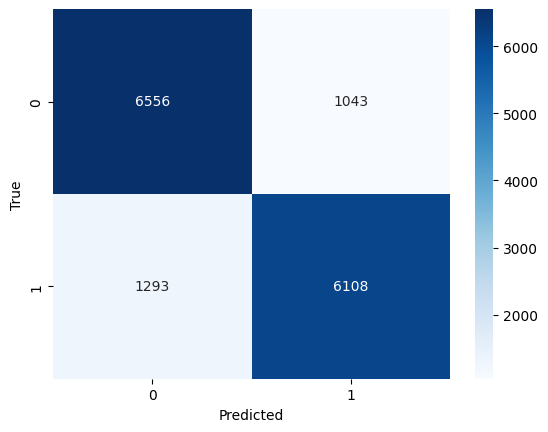

In [ ]:
mostrarPerformance(model_bayes, X_test_count, y_test)

              precision    recall  f1-score   support

    negativo       0.85      0.88      0.86     17401
    positivo       0.87      0.84      0.86     17599

    accuracy                           0.86     35000
   macro avg       0.86      0.86      0.86     35000
weighted avg       0.86      0.86      0.86     35000



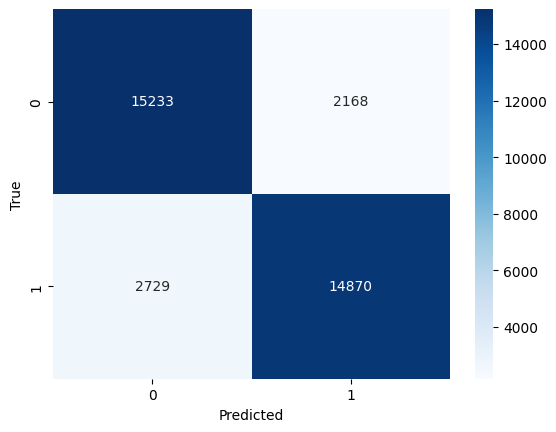

In [ ]:
mostrarPerformance(model_bayes, X_train_count, y_train)

Vemos que contamos con un buen modelo inicial, con metricas bastante elevadas para ser el primero, y si bien sobreajusta, no es tan grave.

In [ ]:
filename = "multinomia_cv.pickle"

# save model
pickle.dump(model_bayes, open(filename, "wb"))

## Multinomial con TFIDF

En este caso estaremos aplicando a nuestro dataset un transformador del tipo TFIDF, que en lugar de medir ocurrencias, mide la frecuencia de aparicion de una palabra, respecto de todas las palabras que hay. Este otorga una puntuacion que indica la importancia relativa de un término en un documento en comparación con el resto de los documentos en la colección. Decidimos eliminar las palabras cuyo valor sea mayor que 0.5, ya que si aparecen muchisimo hay chances de que las palabras sean conectores que no agregan mucha opinion, y a su vez eliminamos las que tienen un valor por debajo de 0.025, ya que podrian ser errores de tipeo, entre otras cosas que agregarian ruido unicamente.

In [ ]:
tfidf_transformer = TfidfVectorizer(smooth_idf=True, max_df=0.5, min_df=0.025)
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)

Generamos nuevamente el modelo, y lo entrenamos con nuestro conjunto transformado.

In [ ]:
model_bayes_transformer = MultinomialNB()
model_bayes_transformer.fit(X_train_tfidf, y_train)

MultinomialNB()

Mostramos la performance en ambos test y train

              precision    recall  f1-score   support

    negativo       0.84      0.78      0.80      7599
    positivo       0.79      0.84      0.81      7401

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000



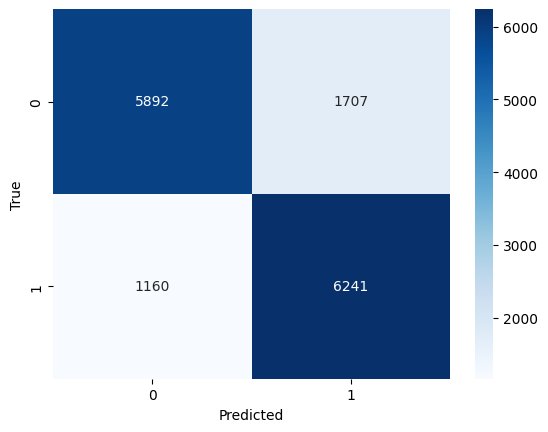

In [ ]:
mostrarPerformance(model_bayes_transformer, X_test_tfidf, y_test)

              precision    recall  f1-score   support

    negativo       0.84      0.78      0.81     17401
    positivo       0.80      0.85      0.82     17599

    accuracy                           0.82     35000
   macro avg       0.82      0.82      0.82     35000
weighted avg       0.82      0.82      0.82     35000



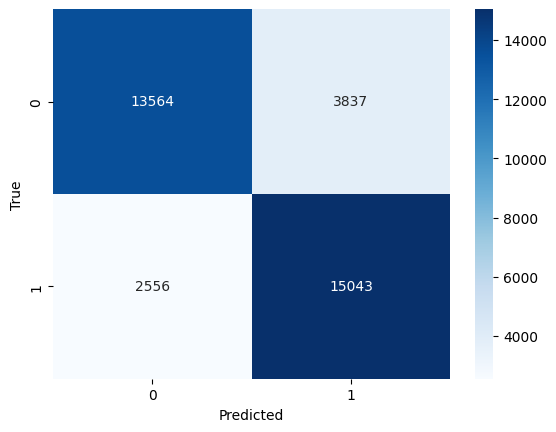

In [ ]:
mostrarPerformance(model_bayes_transformer, X_train_tfidf, y_train)

Notamos que las predicciones en el set de test han empeorado, pero la brecha con el set de entrenamiento se achico, por lo que al menos podemos decir que logramos reducir un poco el sobreajuste.

Exportamos ahora el modelo

In [ ]:
filename = "multinomial_tfidf.pickle"

# save model
pickle.dump(model_bayes_transformer, open(filename, "wb"))

## Bernoulli con TFIDF

Dada la naturaleza de nuestro problema, deberiamos poder usar un clasificador de tipo Bernoulli tambien. Es eso lo que haremos, y analizaremos cual nos da mejor. Estaremos usando el dataset modifcado con TFIDF en el paso anterior. Generamos este tipo de modelo y lo entrenamos.

In [ ]:
model_bayes_bernoulli = BernoulliNB()
model_bayes_bernoulli.fit(X_train_tfidf, y_train)

BernoulliNB()

Realizamos las predicciones

              precision    recall  f1-score   support

    negativo       0.84      0.76      0.79      7599
    positivo       0.77      0.85      0.81      7401

    accuracy                           0.80     15000
   macro avg       0.80      0.80      0.80     15000
weighted avg       0.81      0.80      0.80     15000



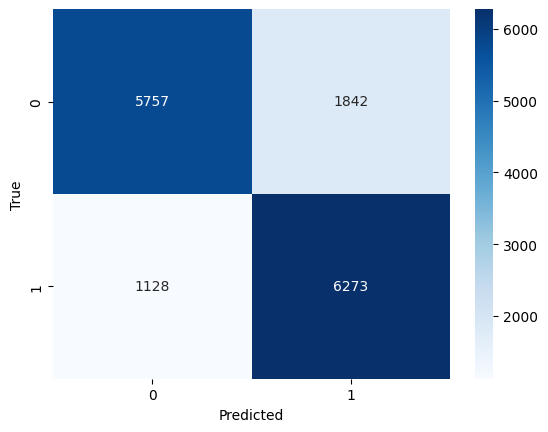

In [ ]:
mostrarPerformance(model_bayes_bernoulli, X_test_tfidf, y_test)

              precision    recall  f1-score   support

    negativo       0.84      0.76      0.80     17401
    positivo       0.78      0.86      0.82     17599

    accuracy                           0.81     35000
   macro avg       0.81      0.81      0.81     35000
weighted avg       0.81      0.81      0.81     35000



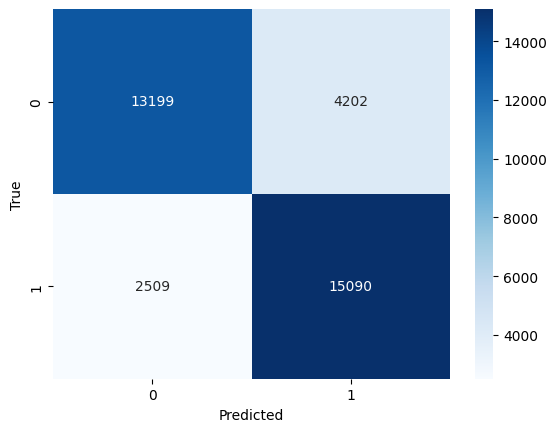

In [ ]:
mostrarPerformance(model_bayes_bernoulli, X_train_tfidf, y_train)

Vemos que este ultimo dio levemente peor que el anterior, pero seguimos contando con un sobreajuste regulado, pareciera estar generalizando bastante bien. Queremos ahora saber si es por nuestro problema que conviene usar un count vectorizer antes que un TFIDF, o si simplemente es casualidad, y si realmente es mejor el modelo multinomial para nuestras condiciones o si nuevamente, es mera coincidencia.

In [ ]:
filename = "bernoulli_tfidf.pickle"

# save model
pickle.dump(model_bayes_bernoulli, open(filename, "wb"))

## Bernoulli con Count Vectorizer

En esta ocasion, copiaremos el procedimiento realizado para la multinomial con count vectorizer, pero cambiaremos uno de los hiperparametros del vectorizer. Dejaremos que se puedan tener en cuenta palabras en un contexto de hasta 2 palabras, ya que, por ejemplo, no es lo mismo "mas hermosa" que "mas basura".

In [ ]:
count_vect_ber = CountVectorizer(min_df=30, ngram_range= (1,2))
X_train_count = count_vect_ber.fit_transform(X_train)
X_test_count = count_vect_ber.transform(X_test)

Creamos el modelo y lo entrenamos

In [ ]:
model_bayes_bernoulli_cv = BernoulliNB()
model_bayes_bernoulli_cv.fit(X_train_count, y_train)

BernoulliNB()

              precision    recall  f1-score   support

    negativo       0.87      0.85      0.86      7599
    positivo       0.85      0.87      0.86      7401

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



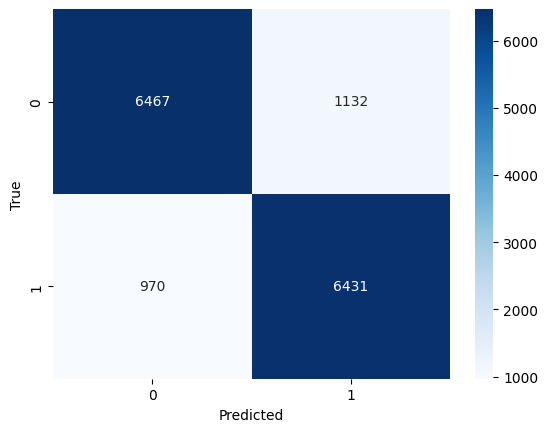

In [ ]:
mostrarPerformance(model_bayes_bernoulli_cv, X_test_count, y_test)

              precision    recall  f1-score   support

    negativo       0.89      0.87      0.88     17401
    positivo       0.87      0.89      0.88     17599

    accuracy                           0.88     35000
   macro avg       0.88      0.88      0.88     35000
weighted avg       0.88      0.88      0.88     35000



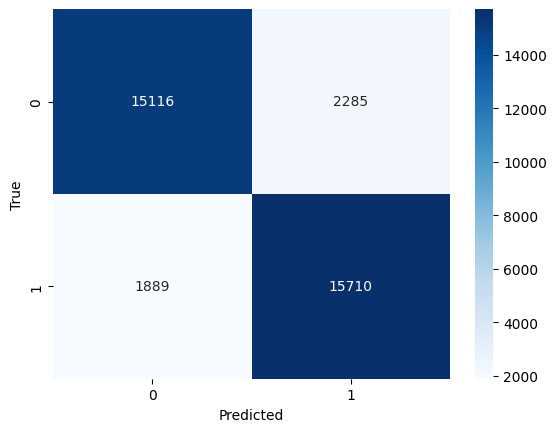

In [ ]:
mostrarPerformance(model_bayes_bernoulli_cv, X_train_count, y_train)

Consideramos que las metricas obtenidas por este modelo, a pesar de continuar sobreajustando, fueron las mejores hasta el momento. Hubo un buen balance entre precision y recall, difiriendo por 0.02, mientras que en la multinomial habia mucho mas, y el f1 score dio alto tambien. Veremos ahora si podemos mejorarlas incluso mas optimizando los parametros.

In [ ]:
filename = "bernoulli_cv.pickle"

# save model
pickle.dump(model_bayes_bernoulli_cv, open(filename, "wb"))

## Optimizacion de hiperparametros en Bernoulli con Count Vectorizer

Realizaremos una busqueda por KFolds para optimizar los hiperparametros de nuestra bernoulli, pero a su vez tambien intentaremos optimizar los del vectorizer, ya que los del primero son muy pocos y notamos que esto tambien es bastante crucial, analizando la performance en los anteriores.

In [ ]:
pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('bn', BernoulliNB())
])

Generamos nuestra grilla de hiperparametros a optimizar. En este caso son pocos los hiperparametros existentes.

In [ ]:
alpha_range = np.linspace(0.1, 1.5, num=10)
from scipy.stats import uniform
param_grid = {'bn__alpha': [0.1, 0.15, 0.2, 0.5, 0.75, 1.0],
              'cv__ngram_range': [(1, 1), (1, 2)],
              'cv__min_df': list(range(5,200)),
              'cv__max_df': uniform(loc=0.4, scale=0.6)}

Codificamos las salidas, mapeando positivo y negativo a 0 y 1

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(["negativo", "positivo"])
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Realizamos la busqueda de hiperparametros haciendo uso de nuestra funcion, con 5 folds y 20 intentos

In [ ]:
optimized_bayes = buscarMejoresHiperparametros(20, 5, pipeline, param_grid, X_train, y_train_encoded)

Best parameters: {'bn__alpha': 0.2, 'cv__max_df': 0.41235069657748147, 'cv__min_df': 6, 'cv__ngram_range': (1, 2)}
Best score: 0.8703864908765098


Vemos que como maximo de apariciones tiene las palabras que aparecen en mas del 41% de las veces, mientras que el minimo de apariciones es 6. Notamos que no esta haciendo un gran recorte por debajo, mientras que si por arriba.

Realizamos las predicciones en ambos conjuntos

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7599
           1       0.87      0.87      0.87      7401

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



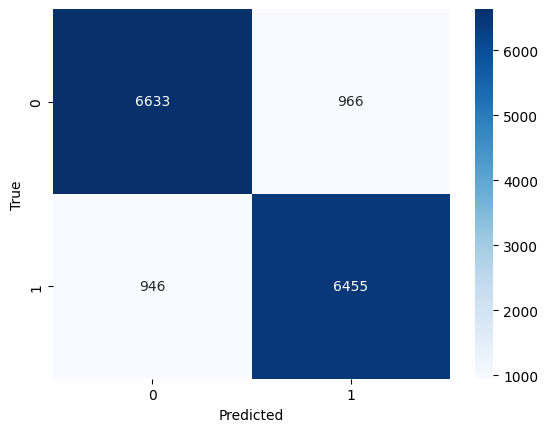

In [ ]:
mostrarPerformance(optimized_bayes, X_test, y_test_encoded)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     17401
           1       0.94      0.93      0.94     17599

    accuracy                           0.94     35000
   macro avg       0.94      0.94      0.94     35000
weighted avg       0.94      0.94      0.94     35000



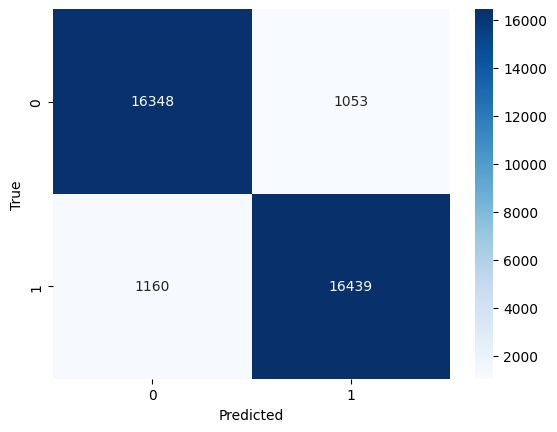

In [ ]:
mostrarPerformance(optimized_bayes, X_train, y_train_encoded)

Observamos que las metricas mejoraron en el set de testeo, pero muchisimo mas en el conjunto de entrenamiento que en este, por lo podemos afirmar que aumento mucho el sobreajuste. Aunque da bien en ambos, no esta generalizando tan bien.

In [ ]:
filename = "bernoulli_kfolds.pickle"

# save model
pickle.dump(optimized_bayes, open(filename, "wb"))

# Random Forest

El modelo a construir ahora sera un random forest. Comenzamos separando el dataset en train y test nuevamente.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(ds_normalizado['review_es'],
                                                 ds_normalizado['sentimiento'],
                                                 test_size =0.30,
                                                 random_state=25,
                                                 shuffle=True)

## Random Forest sin optimizar con Count Vectorizer

Haremos en primer lugar, una version no optimizada, en que los hiperparametros seran los que vienen por defecto.  En lugar de tomar el approach previo en que vamos entrenando el modelo de a poco, construiremos un pipeline, que haga el bag of words y aplique el transformador.

In [ ]:
random_forest = Pipeline([
    ('cv', CountVectorizer(min_df = 20)),
    ('rf', RandomForestClassifier())
])

Entrenamos el pipeline con los datos de entrenamiento

In [ ]:
random_forest.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(min_df=20)),
                ('rf', RandomForestClassifier())])

Realizamos las predicciones con este primer modelo basico.

              precision    recall  f1-score   support

    negativo       0.83      0.84      0.84      7599
    positivo       0.84      0.83      0.83      7401

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



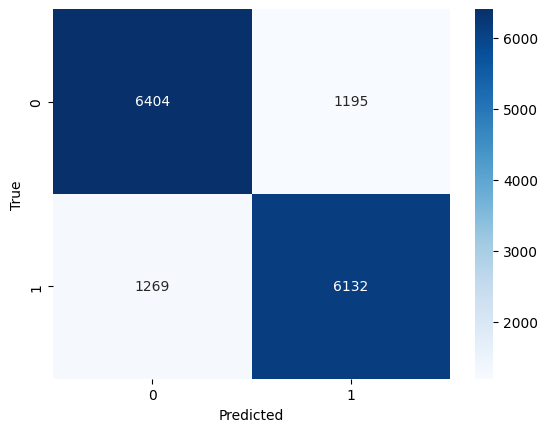

In [ ]:
mostrarPerformance(random_forest, X_test, y_test)

              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00     17401
    positivo       1.00      1.00      1.00     17599

    accuracy                           1.00     35000
   macro avg       1.00      1.00      1.00     35000
weighted avg       1.00      1.00      1.00     35000



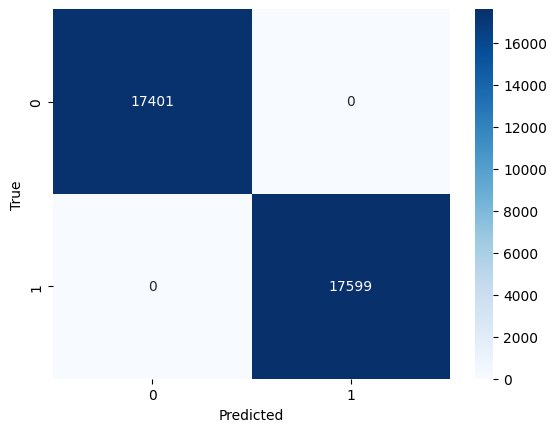

In [ ]:
mostrarPerformance(random_forest, X_train, y_train)

Vemos que no comete ni un error en el set de entrenamiento, por lo que el sobreajuste es total. Ahora, intentaremos optimizar los hiperparametros, tratando de mantener una performance medianamente buena.

In [ ]:
filename = "random_forest.pickle"

# save model
pickle.dump(random_forest, open(filename, "wb"))

## Random Forest optimizado

Creamos nuevamente el pipeline, pero ahora modificando los valores que recibe nuestro encoder. Decidimos settear directamente el ngram range a (1,2), ya que vimos que esto dio buenos resultados anteriormente.

In [ ]:
pipeline = Pipeline([
    ('cv', CountVectorizer(ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

Definimos los rangos de los hiperparametros que queremos optimizar, siendo algunos del random forest y otros del count vectorizer.

In [ ]:
param_rf = {
    'rf__n_estimators': list(range(50, 300)),
    'rf__max_depth': list(range(1, 10)),
    'rf__criterion': ['gini', 'entropy'],
    'cv__min_df': list(range(10, 100)),
    'cv__max_df': uniform(loc=0.8, scale=0.2)
}

Dado que para arboles toma salidas binarias, debemos codificar nuestros inputs de "negativo" y "positivo" a 0 y 1.

In [ ]:
y_train_encoded, y_test_encoded = mapear_palabras_a_numeros(y_train, y_test)

Buscamos ahora optimizar los hiperparametros haciendo uso de la funcion que definimos. Intentaremos 10 sets de valores, con 5 folds.

In [ ]:
optimized_rf_2 = buscarMejoresHiperparametros(10, 5, pipeline, param_rf, X_train, y_train_encoded)

Best parameters: {'cv__max_df': 0.8749080237694725, 'cv__min_df': 24, 'rf__criterion': 'gini', 'rf__max_depth': 8, 'rf__n_estimators': 238}
Best score: 0.8182235038330621


Con nuestro modelo optimizado y entrenado, ahora realizaremos predicciones.

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      7599
           1       0.75      0.90      0.81      7401

    accuracy                           0.80     15000
   macro avg       0.81      0.80      0.80     15000
weighted avg       0.81      0.80      0.80     15000



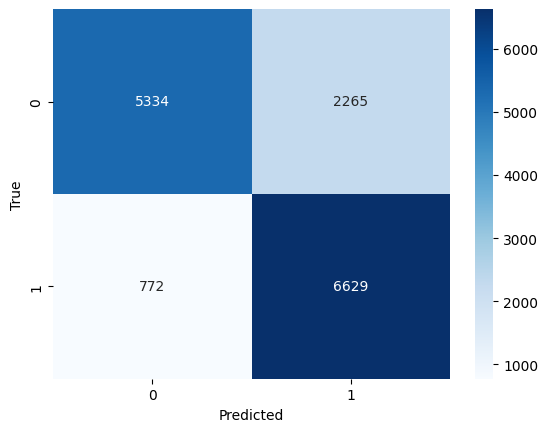

In [ ]:
mostrarPerformance(optimized_rf_2, X_test, y_test_encoded)

              precision    recall  f1-score   support

           0       0.91      0.72      0.80     17401
           1       0.77      0.93      0.84     17599

    accuracy                           0.82     35000
   macro avg       0.84      0.82      0.82     35000
weighted avg       0.84      0.82      0.82     35000



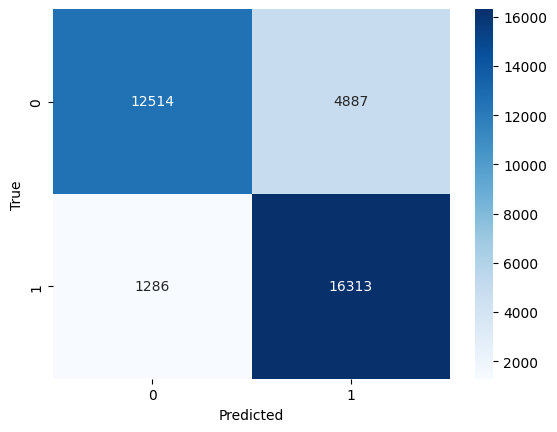

In [ ]:
mostrarPerformance(optimized_rf_2, X_train, y_train_encoded)

Vemos que a este modelo le va "peor" que al anterior en cuanto a metricas del set de testeo, pero la brecha entre test y train es mucho menor. Este modelo sigue sobreajustando pero no tanto. Igualmente, su performance no se acerca siquiera a los peores modelos hechos previamente con bayes naive.

In [ ]:
filename = "random_forest_kfolds.pickle"

# save model
pickle.dump(optimized_rf_2, open(filename, "wb"))

#XGBoost


Separamos el dataset en train y test, usando como target el sentimiento, y como entrada unicamente las resenas, sin el ID.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(ds_normalizado['review_es'],
                                                 ds_normalizado['sentimiento'],
                                                 test_size =0.30,
                                                 random_state=25,
                                                 shuffle=True)

Mapeamos los sentimientos a numeros para que nuestro dataset sea compatible con lo necesario para construir un modelo xgb.

In [ ]:
y_train_encoded, y_test_encoded = mapear_palabras_a_numeros(y_train, y_test)

## Basico

Contruimos un pipeline, que hace utiliza el count vectorizer para la generacion del bag of words, y luego aplica el modelo en si.



In [ ]:
xgb_basico = Pipeline([
    ('cv', CountVectorizer()),
    ('xgb',  xgb.XGBClassifier(random_state=0))
])

Entrenamos el pipeline con los datos de entrenamiento

In [ ]:
xgb_basico.fit(X_train,y_train_encoded)

Pipeline(steps=[('cv', CountVectorizer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      7599
           1       0.82      0.87      0.84      7401

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



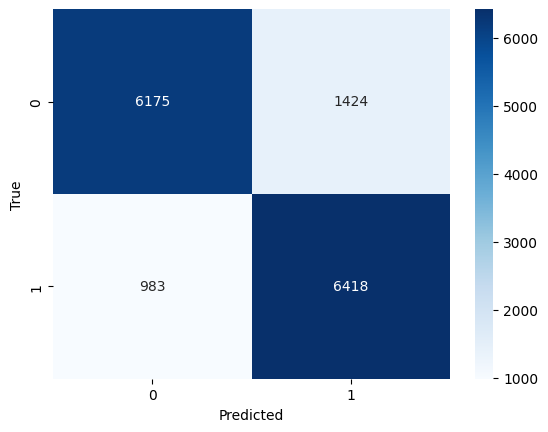

In [ ]:
mostrarPerformance(xgb_basico,X_test,y_test_encoded)

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     17401
           1       0.89      0.94      0.91     17599

    accuracy                           0.91     35000
   macro avg       0.91      0.91      0.91     35000
weighted avg       0.91      0.91      0.91     35000



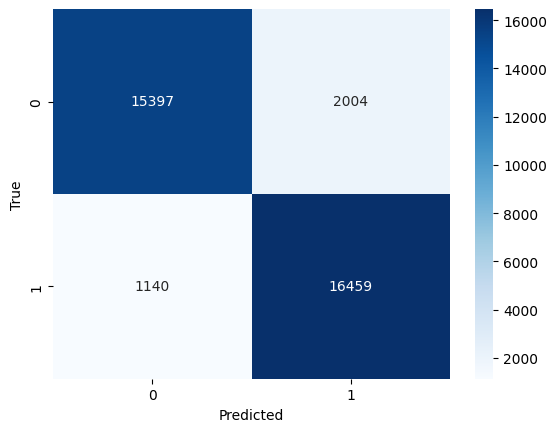

In [ ]:
mostrarPerformance(xgb_basico,X_train,y_train_encoded)

Notamos que si bien la performance no es mala, le va muchisimo mejor en el set de testeo, por lo que podemos afirmar que el modelo esta realizando muchisimo sobreajuste.

In [ ]:
filename = "xgb_basico.pickle"

# save model
pickle.dump(xgb_basico, open(filename, "wb"))

## XGB optimizado

Elegimos parametros a optimizar.

In [ ]:
param_xgb = {
    'xgb__learning_rate': np.linspace(0.05, 0.2, 10),
    'xgb__max_depth': list(range(3, 10)),
    'xgb__subsample': np.linspace(0.5, 1.0, 5),
    'xgb__n_estimators': list(range(50, 200)),
    'xgb__gamma': np.linspace(0.1, 3.0,5 ),
    'xgb__lambda': np.linspace(0.1, 3.0, 5),
    'cv__ngram_range':[ (1, 1), (1, 2)],
    'cv__min_df': list(range(1, 10)),
    'cv__max_df': np.linspace(0.8, 1.0, 10),
}

Buscamos optimizar estos hiperparametros. Como metrica a optimizar usamos f1-score y elegimos 4 folds.

In [ ]:
optimized_xgb = buscarMejoresHiperparametros(6, 4, xgb_basico, param_xgb, X_train, y_train_encoded)

Best parameters: {'xgb__subsample': 0.875, 'xgb__n_estimators': 72, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.2, 'xgb__lambda': 2.275, 'xgb__gamma': 0.1, 'cv__ngram_range': (1, 2), 'cv__min_df': 4, 'cv__max_df': 0.9111111111111111}
Best score: 0.8336246440316248


              precision    recall  f1-score   support

           0       0.85      0.81      0.83      7599
           1       0.81      0.86      0.83      7401

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



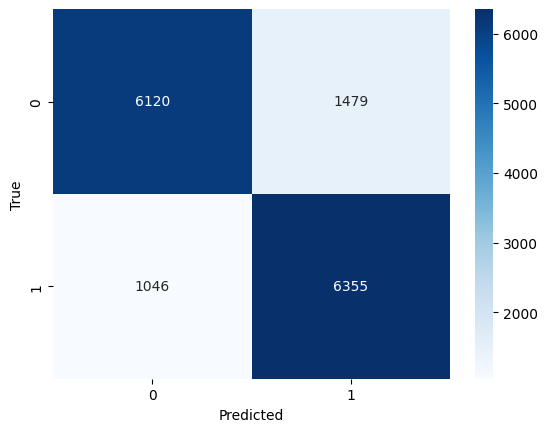

In [ ]:
mostrarPerformance(optimized_xgb,X_test,y_test_encoded)

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     17401
           1       0.89      0.94      0.91     17599

    accuracy                           0.91     35000
   macro avg       0.91      0.91      0.91     35000
weighted avg       0.91      0.91      0.91     35000



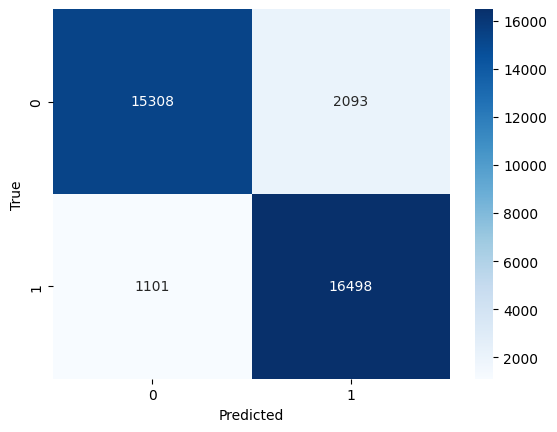

In [ ]:
mostrarPerformance(optimized_xgb, X_train, y_train_encoded)

Notamos que al modelo no le va muy bien; le va hasta peor que al anterior en el set de test y ni siquiera se redujo el sobreajuste.

Exportamos igualmente el modelo, y continuaremos intentando optimizar

In [ ]:
filename = "xgb_optimizado.pickle"

# save model
pickle.dump(optimized_xgb, open(filename, "wb"))

Veremos antes las importancias de las variables que quedaron luego del filtro del Count Vectorizer, para ver si podemos notar alguna data y tomar una decision sobre que hacer con esto.

In [ ]:
importancias_caracteristicas = optimized_xgb.named_steps['xgb'].feature_importances_
nombres_caracteristicas = optimized_xgb.named_steps['cv'].get_feature_names_out()

# Obtener los índices de las características ordenadas por importancia ascendente
indices_ordenados = importancias_caracteristicas.argsort()

# Imprimir las características en orden ascendente
for i in range(len(indices_ordenados)):
    indice = indices_ordenados[i]
    importancia = importancias_caracteristicas[indice]
    if importancia > 0:
      nombre_caracteristica = nombres_caracteristicas[indice]
      print(f"Característica: {nombre_caracteristica}, Importancia: {importancia}")


Vemos que no se esta filtrando correctamente el ruido y que hay muchas palabras que estan ensuciando nuestro dataset. El modelo no cuenta con metodos para prevenir esto pero intentamos aplicar herramientas externas para manejarlo.


## Aplicamos un Stemmer

Para homogenizar el vocabulario con el que contamos, aplicamos un stemmer.

In [ ]:
from nltk.stem.snowball import SpanishStemmer
def lematizar(text):
  stemmer = SpanishStemmer()
  texto_lematizado = text.apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
  return texto_lematizado

In [ ]:
X_train_lematizado = lematizar(X_train)
X_test_lematizado = lematizar(X_test)

Creamos otro modelo con los hiperparametros obtenidos previamente en la optimizacion y lo entrenamos con el set de datos modificado.

In [ ]:
from xgboost.sklearn import xgboost_model_doc
param_xgb = {'learning_rate': 0.2,
             'max_depth': 9,
             'n_estimators': 72,
             'subsample': 0.875,
             'gamma': 0.1,
             'lambda': 0.275,
             'seed' : 0,
}
param_cv = {'ngram_range' : (1,2),
            'min_df': 4,
            'max_df': 0.911,
}
xgb_model = Pipeline([
    ('cv', CountVectorizer(**param_cv)),
    ('xgb',  xgb.XGBClassifier(**param_xgb))
])
xgb_model.fit(X_train_lematizado,y_train_encoded)

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.911, min_df=4, ngram_range=(1, 2))),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, lambda=0.275,
                               learning_rate=0.2, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=72, n_jobs=None,
                               num_parallel_tree=None, predictor=None, ...))])

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     17401
           1       0.92      0.95      0.93     17599

    accuracy                           0.93     35000
   macro avg       0.93      0.93      0.93     35000
weighted avg       0.93      0.93      0.93     35000



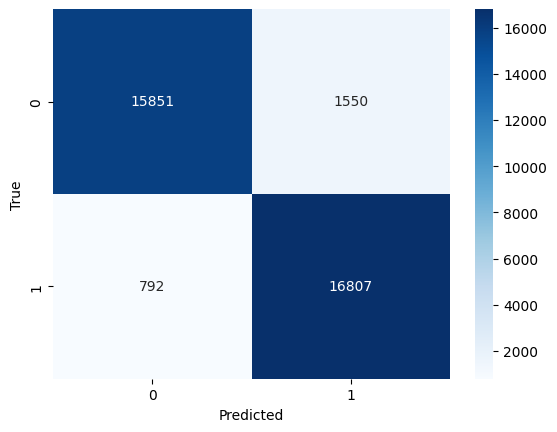

In [ ]:
mostrarPerformanceConBinarizador(xgb_model,X_train_lematizado,y_train_encoded)

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      7599
           1       0.82      0.86      0.84      7401

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



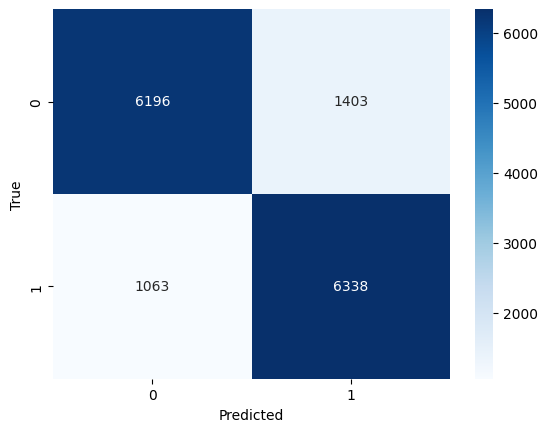

In [ ]:
mostrarPerformanceConBinarizador(xgb_model,X_test_lematizado,y_test_encoded)

Podemos ver que sigue habiendo overfitting, pero las metricas aumentaron al mismo ritmo en ambos set de datos.


In [ ]:
importancias_caracteristicas = xgb_model.named_steps['xgb'].feature_importances_
nombres_caracteristicas = xgb_model.named_steps['cv'].get_feature_names_out()

# Obtener los índices de las características ordenadas por importancia ascendente
indices_ordenados = importancias_caracteristicas.argsort()

# Imprimir las características en orden ascendente
for i in range(len(indices_ordenados)):
    indice = indices_ordenados[i]
    importancia = importancias_caracteristicas[indice]
    nombre_caracteristica = nombres_caracteristicas[indice]
    if importancia > 0:
      print(f"Característica: {nombre_caracteristica}, Importancia: {importancia}")

Podemos ver que se reducen la cantidad de palabras en el vocabulario y que alguna se combinan, aumentando asi su importancia. Seguimos viendo sin embargo que no se filtra correctamente el ruido y que se le da importancia a palabras irrelevantes.

## Aumentamos hiperparametros de regularizacion

In [ ]:
from xgboost.sklearn import xgboost_model_doc
param_xgb = {'learning_rate': 0.2,
             'max_depth': 5,
             'n_estimators': 72,
             'subsample': 0.6,
             'gamma': 0.3,
             'lambda': 0.6,
             'seed' : 0,
}
param_cv = {'ngram_range' : (1,2),
            'min_df': 20,
            'max_df': 0.911,
}
xgb_model = Pipeline([
    ('cv', CountVectorizer(**param_cv)),
    ('xgb',  xgb.XGBClassifier(**param_xgb))
])
xgb_model.fit(X_train,y_train_encoded)

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.911, min_df=20, ngram_range=(1, 2))),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.3, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, lambda=0.6,
                               learning_rate=0.2, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=72, n_jobs=None,
                               num_parallel_tree=None, predictor=None, ...))])

              precision    recall  f1-score   support

           0       0.89      0.81      0.84     17401
           1       0.82      0.90      0.86     17599

    accuracy                           0.85     35000
   macro avg       0.86      0.85      0.85     35000
weighted avg       0.85      0.85      0.85     35000



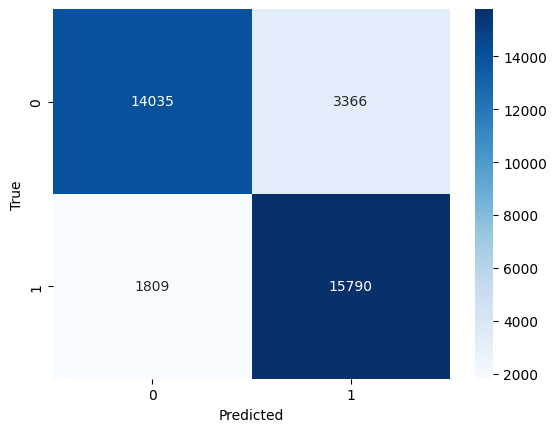

In [ ]:
mostrarPerformanceConBinarizador(xgb_model,X_train,y_train_encoded)

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      7599
           1       0.79      0.86      0.82      7401

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



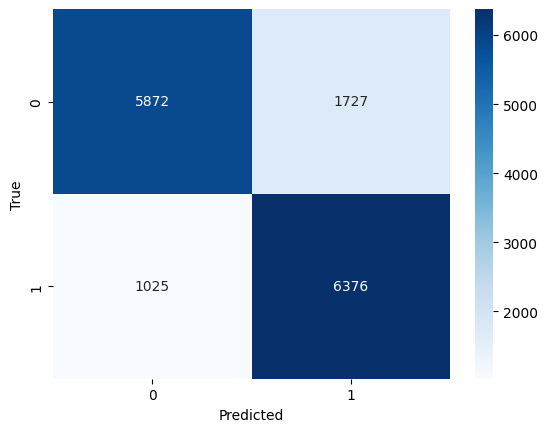

In [ ]:
mostrarPerformanceConBinarizador(xgb_model,X_test,y_test_encoded)

# Modelo de red neuronal aplicando Keras y Tensor Flow

## Modelo con una capa oculta y dropout

Entrenaremos ahora una red neuronal con el fin de predecir el sentimiento de las resenas. Empezamos separando como antes el dataset en train y test. Realizaremos un primer modelo casi de la misma manera que trabajamos en el trabajo anterior.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(ds_normalizado.review_es,
                                                 ds_normalizado.sentimiento,
                                                 test_size =0.30,
                                                 random_state=25,
                                                 shuffle=True)

Crearemos nuestro bag of words mediante la funcion Count Vectorizer, setteando como hiperparametros los elegidos para Bayes Naive con bernoulli, pues este modelo tuvo una alta performance.

In [ ]:
count_vect_neuronal = CountVectorizer(min_df=30, ngram_range= (1,2))
X_train_count = count_vect_neuronal.fit_transform(X_train)
X_test_count = count_vect_neuronal.transform(X_test)

Codificamos nuevamente el target, de palabras a 0s y 1s ya que la funcion lo requiere

In [ ]:
y_train_encoded, y_test_encoded = mapear_palabras_a_numeros(y_train, y_test)

Armamos la red con 1 unica capa oculta. En la capa de salida usamos como funcion de activacion la sigmoidea, dada la naturaleza de nuestro problema. Agregamos ademas, dropout entre capas con el fin de reducir el sobreajuste. Luego compilamos el modelo usando como optimizador adam, ya que este es muy usado y suele ser bueno, y la entropia binaria cruzada.

In [ ]:
input_dim = (X_train_count.shape[1],)

red = Sequential()
input_shape = (input_dim,)
red.add(Dense(100, activation='relu', input_shape=input_dim))
red.add(Dropout(0.18))
red.add(Dense(50, activation='relu'))
red.add(Dropout(0.15))
red.add(Dense(1, activation='sigmoid'))

red.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
red.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2016700   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,021,801
Trainable params: 2,021,801
Non-trainable params: 0
_________________________________________________________________


Entrenamos entonces al modelo, usando un tamano de lote de 32, pasando los fragmentos del vector de a fragmentos a array, ya si pasamos toda la X_train a array, el entorno se satura y se corta, pues se gasta toda la RAM disponible.

In [ ]:
batch_size = 32

# Obtener el número total de muestras de entrenamiento
num_samples = X_train_count.shape[0]

# Entrenar el modelo en lotes secuenciales
for i in range(0, num_samples, batch_size):
    start = i
    end = min(i + batch_size, num_samples)
    X_batch = X_train_count[start:end].toarray()
    y_batch = y_train_encoded[start:end]
    red.train_on_batch(X_batch, y_batch)


Pasamos ahora el conjunto de testeo a un array de forma directa, ya que este es mas chico y no genera problemas, y luego realizamos predicciones sobre este.

469/469 [==============================] - 5s 9ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      7599
           1       0.85      0.92      0.88      7401

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



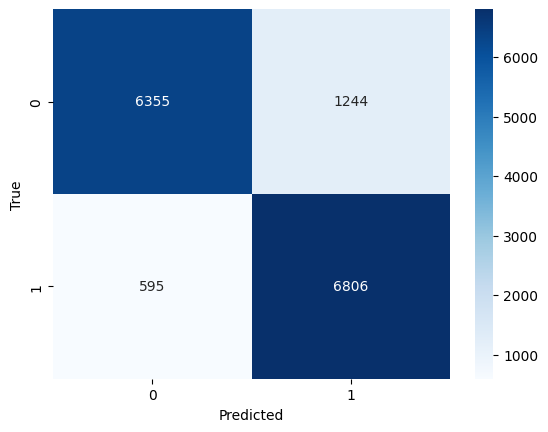

In [ ]:
X_test_dense = X_test_count.toarray()
mostrarPerformanceConBinarizador (red, X_test_dense, y_test_encoded)

Vemos que a este modelo le va muy bien. Sin embargo, no podemos confirmar que no este sobreajustando, pues no podemos probarlo en el conjunto de entrenamiento entero ya que hay problemas con la RAM. Sin embargo podemos observar la perdida y el accuracy del entrenamiento, y vemos que el accuracy del entrenamiento dio igual que el de test, lo cual es una buena senal. Al predecir en kaggle, este modelo tuvo un buen rendimiento.

In [ ]:
filename = "red_neuronal_dropout.pickle"

# save model
pickle.dump(red, open(filename, "wb"))

## Modelo con dos capas ocultas y Early Stopping

Entrenaremos nuevamente una red neuronal como el modelo anterior, con el fin de predecir el sentimiento de las resenas. Pero agregaremos la técnica Early Stopping

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ds_normalizado.review_es,
                                                    ds_normalizado.sentimiento,
                                                    test_size=0.30,
                                                    random_state=25,
                                                    shuffle=True)

Crearemos nuevamente un bag of words mediante la funcion Count Vectorizer, setteando como hiperparametros los elegidos para Bayes Naive con bernoulli, pues este modelo tuvo una alta performance.

In [ ]:
count_vect_neuronal = CountVectorizer(min_df=30, ngram_range=(1, 2))
X_train_count = count_vect_neuronal.fit_transform(X_train)
X_test_count = count_vect_neuronal.transform(X_test)

Codificamos nuevamente el target, de palabras a 0s y 1s

In [ ]:
y_train_encoded, y_test_encoded = mapear_palabras_a_numeros(y_train, y_test)

Armamos la red como el modelo anterior, pero modificando el tamaño de las capas, y agregando una capa oculta extra.


In [ ]:
input_dim = X_train_count.shape[1]

# Creación del modelo
red = Sequential()
red.add(Dense(200, activation='relu', input_dim=input_dim))
red.add(Dropout(0.3))
red.add(Dense(100, activation='relu'))
red.add(Dropout(0.2))
red.add(Dense(50, activation='relu'))
red.add(Dropout(0.1))
red.add(Dense(1, activation='sigmoid'))

red.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
red.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 200)               4033400   
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

Ahora, generamos los datos utilizando una función auxiliar. Lo que hacemos ahora es, en vez de realizar un entrenamiento de a poco, entrenarlo todo junto pero vectorizando de a poco.

In [ ]:
batch_size = 32
train_generator = generador_de_lotes(X_train_count, y_train_encoded, batch_size)

Utilizamos el ***early stopping*** para controlar el proceso de entrenamiento del modelo de red neuronal, para intentar evitar el sobreajuste lo maximo posible.

In [ ]:
# Técnica Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Modelo utilizando el generador de datos
red.fit(train_generator,
        steps_per_epoch=X_train_count.shape[0] // batch_size,
        epochs=100,
        validation_data=(X_test_count.toarray(), y_test_encoded),
        callbacks=[early_stopping])

Epoch 1/100
1093/1093 [==============================] - 84s 75ms/step - loss: 0.3477 - accuracy: 0.8544 - val_loss: 0.2810 - val_accuracy: 0.8861
Epoch 2/100
1093/1093 [==============================] - 64s 59ms/step - loss: 0.1591 - accuracy: 0.9393 - val_loss: 0.3231 - val_accuracy: 0.8762
Epoch 3/100
1093/1093 [==============================] - 71s 65ms/step - loss: 0.0603 - accuracy: 0.9794 - val_loss: 0.4568 - val_accuracy: 0.8786
Epoch 4/100
1093/1093 [==============================] - 78s 71ms/step - loss: 0.0305 - accuracy: 0.9902 - val_loss: 0.5755 - val_accuracy: 0.8717


Ahora, evaluaremos el modelo

In [ ]:
mostrarPerformanceConBinarizador (red, X_test_count.toarray(), y_test_encoded)

In [ ]:
filename = "red_neuronal_early_stopping.pickle"

# save model
pickle.dump(red, open(filename, "wb"))

## Modelo utilizando Early Stopping con TFIDF

Entrenaremos nuevamente una red neuronal como el modelo anterior, con el fin de predecir el sentimiento de las reseñas.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ds_normalizado['review_es'],
                                                    ds_normalizado['sentimiento'],
                                                    test_size=0.3,
                                                    random_state=25,
                                                    shuffle=True)


A diferencia del modelo anterior, se crea una representación de los textos utilizando TF-IDF (Term Frequency-Inverse Document Frequency). Los parámetros min_df consideran las palabras que aparecen al menos en 30 documentos y ngra_range(1,2) indica que considerá las palabras individuales como las combinaciones de dos palabras.

In [ ]:
vectorizer = TfidfVectorizer(min_df=30, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Convertimos las matrices dispersas de representaciones TF-IDF de los textos en tensores dispersos de TensorFlow. Esto nos parecio necesario para poder utilizar los datos en el modelo.


In [ ]:
X_train_tfidf = tf.convert_to_tensor(X_train_tfidf.toarray(), dtype=tf.float32)
X_test_tfidf = tf.convert_to_tensor(X_test_tfidf.toarray(), dtype=tf.float32)


Ahora, utilizamos LabelEncoder para asignar numeros a las etiquetas de las muestras.

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


Creamos el modelo,la primera capa densa tiene 500 neuronas y utiliza la función de activación Relu. El parámetro imput_dim se establece en la dimensión del conjunto de entrenamiento TF-IDF x_train_tfidf. Esto puede asegurarnos que la primera capa tenga la cantidad correcta de neuronas de entrada para procesar las características de los datos.Además agregamos una capa Dropout para desactivar un porcentaje de las neuronas durante el entrenamiento.




In [ ]:
input_dim = X_train_tfidf.shape[1]

# Creación del modelo
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=input_dim))
model.add(Dropout(0.5))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

Compilamos nuestro modelo y imprimimos su resumen.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Entrenamos nuestra red neuronal usando la técnica Early Stopping y con la vectorización TFIDF.

In [ ]:
history = model.fit(X_train_tfidf, y_train_encoded, epochs=20, batch_size=16,
                    validation_split=0.2, callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])


Se obtienen ahora las metricas, pero ahora no podemos usar nuestra funcion ya que no contamos con las entradas que esta requiere

In [ ]:
# Obtener las predicciones del modelo como probabilidades
y_pred_prob = model.predict(X_test_tfidf)

# Aplicar umbral de 0.5 para convertir las probabilidades en etiquetas binarias
y_pred = (y_pred_prob >= 0.5).astype(int)

# Convertir las etiquetas predichas a valores originales
y_pred_original = label_encoder.inverse_transform(y_pred.flatten())

# Convertir las etiquetas originales a valores originales
y_test_original = label_encoder.inverse_transform(y_test_encoded)

# Calcular las métricas
accuracy = accuracy_score(y_test_original, y_pred_original)
precision = precision_score(y_test_original, y_pred_original, average='weighted')
recall = recall_score(y_test_original, y_pred_original, average='weighted')
f1 = f1_score(y_test_original, y_pred_original, average='weighted')

# Imprimir el informe de métricas
print("Informe de métricas para el conjunto de prueba:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Predecimos tambien sobre el set de entrenamiento

In [ ]:
# Obtener las predicciones del modelo para el conjunto de entrenamiento
y_train_pred_prob = model.predict(X_train_tfidf)
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)

# Convertir las etiquetas codificadas del conjunto de entrenamiento a valores originales
y_train_original = label_encoder.inverse_transform(y_train_encoded)

# Convertir las etiquetas predichas del conjunto de entrenamiento a valores originales
y_train_pred_original = label_encoder.inverse_transform(y_train_pred.flatten())

# Calcular las métricas para el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train_original, y_train_pred_original)
train_precision = precision_score(y_train_original, y_train_pred_original, average='weighted')
train_recall = recall_score(y_train_original, y_train_pred_original, average='weighted')
train_f1 = f1_score(y_train_original, y_train_pred_original, average='weighted')

# Imprimir el informe de métricas para el conjunto de entrenamiento
print("Informe de métricas para el conjunto de entrenamiento:")
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)
print("F1-Score:", train_f1)


In [ ]:
filename = "red_neuronal_es_tfidf.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

# Ensambles Elegidos

## Voting


### Voting Hibrido

Entrenaremos ahora un ensamble hibrido, con el fin de predecir el sentimiento de las resenas. Empezamos separando como antes el dataset en train y test.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(ds_normalizado['review_es'],
                                                 ds_normalizado['sentimiento'],
                                                 test_size =0.30,
                                                 random_state=25,
                                                 shuffle=True)

In [ ]:
y_train_encoded, y_test_encoded = mapear_palabras_a_numeros(y_train, y_test)


Elegimos como modelos base una variedad de los distintos modelos vistos a lo largo de la materia, esperando que combinarlos implique un modelo mas fuerte.

In [ ]:
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC(probability = True)),
               ('knn', KNeighborsClassifier(n_neighbors=11)),
               ('xgb', xgb.XGBClassifier())]


In [ ]:
pipeline = Pipeline([
    ('cv', CountVectorizer(min_df=1000)),
    ('vot',  VotingClassifier(estimators = base_models, voting = 'soft'))
])

In [ ]:
pipeline.fit(X_train,y_train_encoded)

Pipeline(steps=[('cv', CountVectorizer(min_df=1000)),
                ('tfidf', TfidfTransformer()),
                ('vot',
                 VotingClassifier(estimators=[('random_forest',
                                               RandomForestClassifier(n_estimators=50)),
                                              ('svm', SVC(probability=True)),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=11)),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_by...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...))],
                                  voting='soft'))])

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      7599
           1       0.80      0.86      0.83      7401

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



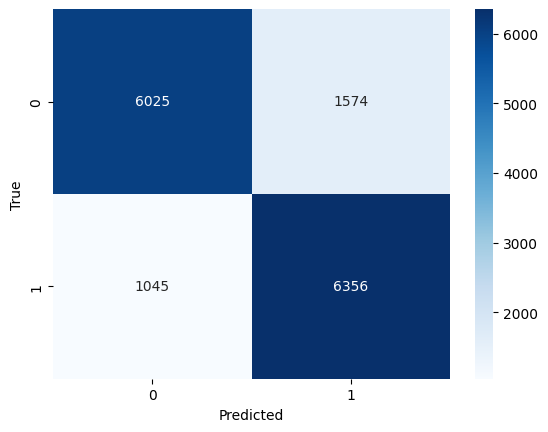

In [ ]:
mostrarPerformance(pipeline,X_test,y_test_encoded)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     17401
           1       0.95      0.98      0.96     17599

    accuracy                           0.96     35000
   macro avg       0.96      0.96      0.96     35000
weighted avg       0.96      0.96      0.96     35000



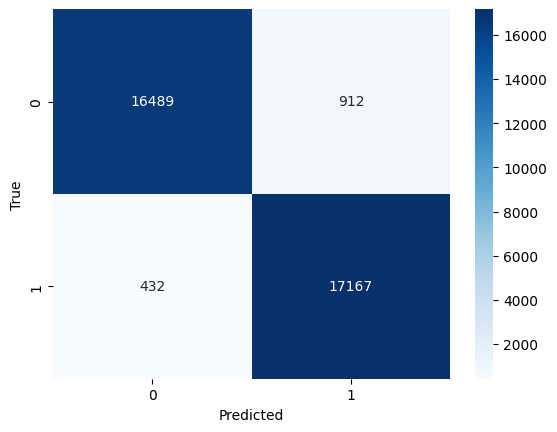

In [ ]:
mostrarPerformance(pipeline,X_train,y_train_encoded)

Notamos que el modelo esta haciendo overfitting

### Voting con SVM

Entrenaremos ahora un ensamble hibrido "Voting con SVM",con el fin de predecir el sentimiento de las resenas. Empezamos separando como antes el dataset en train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ds_normalizado['review_es'],
                                                    ds_normalizado['sentimiento'],
                                                    test_size=0.30,
                                                    random_state=25,
                                                    shuffle=True)

En este caso, utilizamosel LabelEncoder para codificar las etiquetas de clase en valores numéricos. Esto es necesario para que el algoritmo SVM pueda trabajar con las etiquetas en formato numérico.

In [ ]:
y_train_encoded, y_test_encoded = mapear_palabras_a_numeros(y_train, y_test)

Los modelos se utilizaran  con diferentes kernels: svm_linear con kernel lineal, svm_rbf con kernel radial basis function (RBF) y svm_poly con kernel polinomial de grado 3.

In [ ]:
svm_linear = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')
svm_poly = SVC(kernel='poly', degree=3)


Construimos el modelo Voting con la clase VotingClassifer

In [ ]:
voting_model = VotingClassifier(estimators=[('svm_linear', svm_linear),
                                            ('svm_rbf', svm_rbf),
                                            ('svm_poly', svm_poly)],
                                voting='hard')


En este caso, construimos el pipeline con la etapa de vectorización usando CountVectorizer y el modelo voting creado anteriormente. El vectorizador se encarga de convertir el texto en representaciones numéricas.

In [ ]:
voting_pipeline_svm = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('voting', voting_model)
])

Acá se puede visualizar,durante el entrenamiento, los modelos SVM son ajustados y el modelo de Voting aprende a combinar sus predicciones.

In [ ]:
voting_pipeline_svm.fit(X_train, y_train_encoded)


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('voting',
                 VotingClassifier(estimators=[('svm_linear',
                                               SVC(kernel='linear')),
                                              ('svm_rbf', SVC()),
                                              ('svm_poly',
                                               SVC(kernel='poly'))]))])

Se realizan predicciones utilizando el pipeline entrenado y los datos de prueba.

In [ ]:
y_pred = voting_pipeline_svm.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Precisión en el conjunto de prueba:", accuracy)

Precisión en el conjunto de prueba: 0.8666


              precision    recall  f1-score   support

           0       0.91      0.81      0.86      7599
           1       0.83      0.92      0.87      7401

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



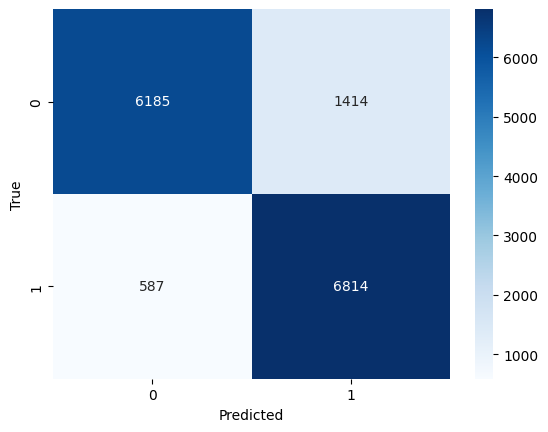

In [ ]:
mostrarPerformance(voting_pipeline_svm,X_test,y_test_encoded)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     17401
           1       0.95      0.99      0.97     17599

    accuracy                           0.97     35000
   macro avg       0.97      0.97      0.97     35000
weighted avg       0.97      0.97      0.97     35000



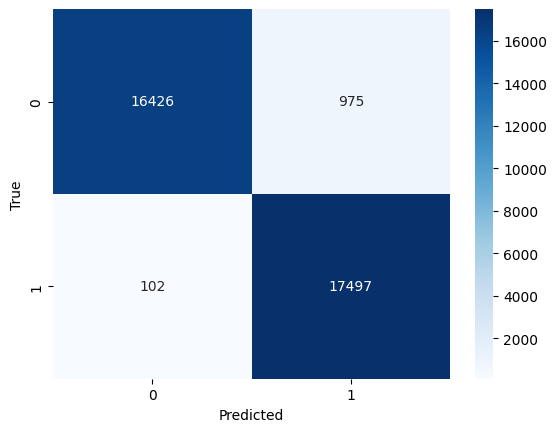

In [ ]:
mostrarPerformance(voting_pipeline_svm,X_train,y_train_encoded)

### Voting de Bayes Naive

Creamos otro modelo de la misma manera que el anterior, pero en que los modelos seran de bayes naive

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ds_normalizado['review_es'],
                                                    ds_normalizado['sentimiento'],
                                                    test_size=0.30,
                                                    random_state=25,
                                                    shuffle=True)

In [ ]:
y_train_encoded, y_test_encoded = mapear_palabras_a_numeros(y_train, y_test)

Creamos los modelos base y el pipeline en que se aplicara el vectorizador y luego los modelos

In [ ]:
model1 = BernoulliNB(alpha=0.2)
model2 = BernoulliNB()
model3 = MultinomialNB()

# Construimos el modelo de stacking
estimators = [('model1', model1), ('model2',model2), ('model3', model3)]
voting_bayes = Pipeline([
    ('cv', CountVectorizer(min_df=30, ngram_range=(1, 2))),
    ('vt',  VotingClassifier(estimators=estimators, voting='hard'))
])

Entrenamos al modelo

In [ ]:
voting_bayes.fit(X_train, y_train_encoded)

Pipeline(steps=[('cv', CountVectorizer(min_df=30, ngram_range=(1, 2))),
                ('st',
                 VotingClassifier(estimators=[('model1',
                                               BernoulliNB(alpha=0.2)),
                                              ('model2', BernoulliNB()),
                                              ('model3', MultinomialNB())]))])

Predecimos sobre ambos sets

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7599
           1       0.85      0.87      0.86      7401

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



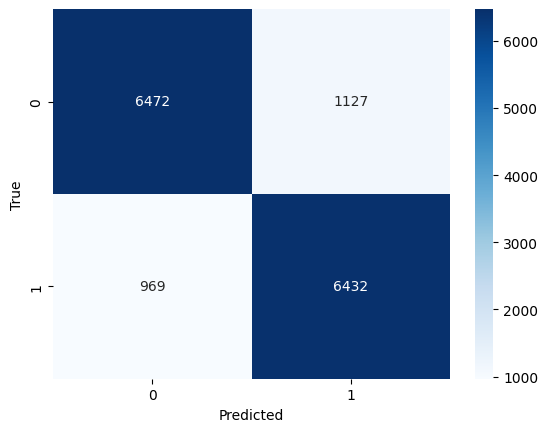

In [ ]:
mostrarPerformance(voting_bayes, X_test, y_test_encoded)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     17401
           1       0.87      0.89      0.88     17599

    accuracy                           0.88     35000
   macro avg       0.88      0.88      0.88     35000
weighted avg       0.88      0.88      0.88     35000



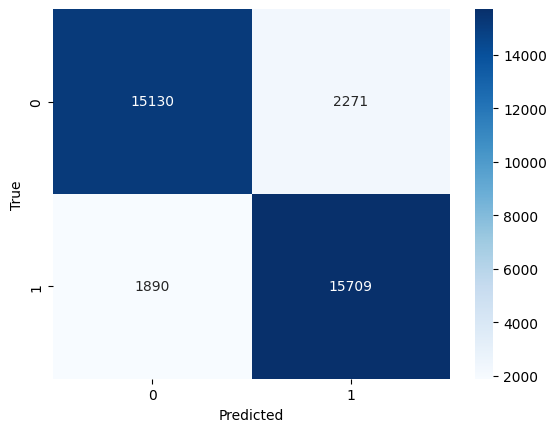

In [ ]:
mostrarPerformance(voting_bayes, X_train, y_train_encoded)

Notamos que no solo a este modelo le fue mucho mejor que a los anteriores sino que ademas redujo muchisimo el sobreajuste. Lo exportamos

In [ ]:
filename = "voting_bayes.pickle"

# save model
pickle.dump(voting_bayes, open(filename, "wb"))

### Optimizacion de hiperparametros de voting Bayes

Dado el rendimiento del modelo, intentaremos optimizar los hiperparametros de todos los modelos que componen el pipeline.

In [ ]:
from scipy.stats import uniform
param_grid = {
    'vt__model1__alpha': np.linspace(0.1, 1.5, num=10),
    'vt__model2__alpha': np.linspace(0.1, 1.5, num=10),
    'vt__model3__alpha': np.linspace(0.1, 1.5, num=10),
    'cv__ngram_range': [(1, 1), (1, 2)],
    'cv__min_df': list(range(5,200)),
    'cv__max_df': uniform(loc=0.7, scale=0.2)
}

voting_bayes_optimizado= buscarMejoresHiperparametros(10, 5, voting_bayes, param_grid, X_train, y_train_encoded)

Best parameters: {'cv__max_df': 0.7900998503939085, 'cv__min_df': 22, 'cv__ngram_range': (1, 2), 'vt__model1__alpha': 1.3444444444444446, 'vt__model2__alpha': 0.25555555555555554, 'vt__model3__alpha': 1.5}
Best score: 0.8640512127026307


Predecimos ahora con el nuevo modelo en ambos sets

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7599
           1       0.85      0.87      0.86      7401

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



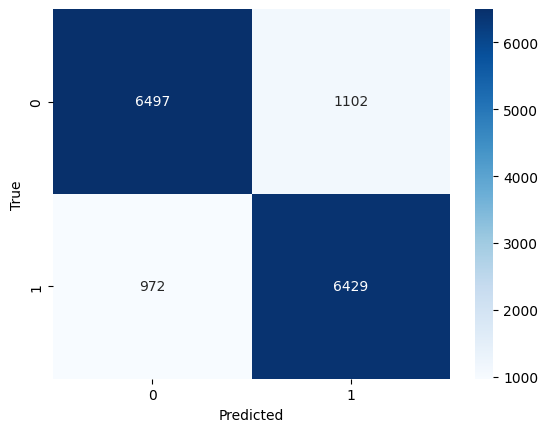

In [ ]:
mostrarPerformance(voting_bayes_optimizado, X_test, y_test_encoded)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     17401
           1       0.88      0.89      0.89     17599

    accuracy                           0.89     35000
   macro avg       0.89      0.89      0.89     35000
weighted avg       0.89      0.89      0.89     35000



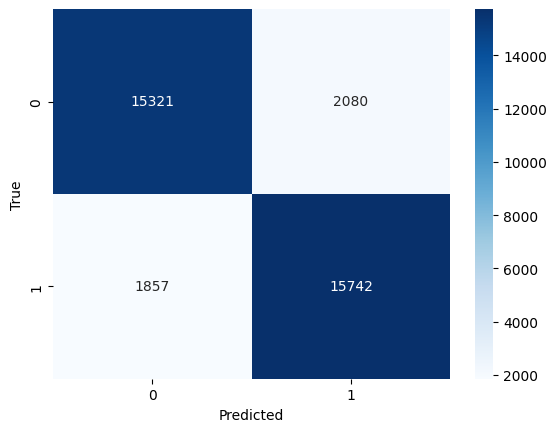

In [ ]:
mostrarPerformance(voting_bayes_optimizado, X_train, y_train_encoded)

Notamos que las metricas mejoraron ahora sobre el set de entrenamiento, pero no sobre el set de testeo, por lo que concluimos que aumento su sobreajuste, y no su rendimiento. Exportamos igualmente el modelo.

In [ ]:
filename = "voting_bayes_optimizado.pickle"

# save model
pickle.dump(voting_bayes_optimizado, open(filename, "wb"))

# Preparacion del dataset para realizar predicciones

In [ ]:
ds = pd.read_csv('https://drive.google.com/uc?export=download&id=1x3Q8Q1dt7G3XkNJj-AcpTNTMrpmgiMV0', index_col=None)
ds_x_test = ds.copy()

Aplicamos el preprocesamiento al set de testeo

In [ ]:
ds_x_test["review_es"] = ds_x_test["review_es"].apply(sacar_tildes)
ds_x_test["review_es"] = ds_x_test["review_es"].apply(limpiar_texto)
ds_x_test["review_es"] = ds_x_test["review_es"].apply(remover_conectores)

NameError: ignored

Creamos esta funcion para convertir predicciones binarias a predicciones en palabras

In [ ]:
def convertir_pred_numericas_a_palabras(ds_y_test):
  label_mapping = {
    0: "negativo",
    1: "positivo"
  }

  # Decodificar los valores numéricos a etiquetas originales
  y_pred = [label_mapping[value] for value in ds_y_test]
  return y_pred

Creamos dos funciones para generar predicciones. La primera predice sobre modelos que devuelven como respuesta valores binarios, por lo que debemos mapear estos a palabras.

In [ ]:
def predecir_test_binario(x, model, name):
  ds_y_test = convertir_pred_numericas_a_palabras(model.predict(x["review_es"]))
  ds_submission = pd.DataFrame({'id': x['ID'], 'sentimiento': ds_y_test})
  ds_submission.to_csv(name, index=False)

Esta segunda hace lo mismo que la anterior, pero sin realizar dicho mapeo ya que devuelve directamente la respuesta en palabras.

In [ ]:
def predecir_test(x, model, name):
  ds_y_test = model.predict(x["review_es"])
  ds_submission = pd.DataFrame({'id': x['ID'], 'sentimiento': ds_y_test})
  ds_submission.to_csv(name, index=False)

## Prediccion Bayes

In [ ]:
predecir_test(ds_x_test, model_bayes, 'bayes_bernoulli.csv')

## Prediccion Random Forest

In [ ]:
predecir_test_binario(ds_x_test, optimized_rf_2, 'random_forest_optimizado.csv')

## Prediccion XGB


In [ ]:
predecir_test_binario(ds_x_test, xgb_model, 'model_xgb_conservador.csv')

## Predicción Ensambles Hibridos:Voting

In [ ]:
predecir_test_binario(ds_x_test, voting_pipeline_svm, 'model_stacking_svm.csv')

## Predicción Red Neuronal

In [ ]:
#Realizamos las predicciones

#ds_x = count_vect_ber.transform()
X_test_count = vectorizer.transform(ds_x_test["review_es"])
X_test = X_test_count.toarray()
ds_y_test = model.predict(X_test)
ds_y_bin = pasar_prediccion_a_binario(ds_y_test)
ds_y_opt = mapear_numeros_a_palabras(ds_y_bin)


269/269 [==============================] - 7s 27ms/step


In [ ]:
ds_submission = pd.DataFrame({'id': ds_x_test['ID'], 'sentimiento': ds_y_opt})
ds_submission.to_csv('model_red_6.csv', index=False)